## Data Cleaning & EDA

The purpose of this project is to make hotel recommendations to users based on a Hybrid Recommender system utilizing content based and collaborative filtering. 

There will be two notebooks to demonstrate this process. This one, the first, will illustrate the preprocessing steps and data exploration to feed into machine learning algorithms. There will also be an intermediate clustering step to cluster users as there is an immense amount of users in the original dataset, making it difficult to run matrix factorization (computational cost).

The second notebook will illustrate the modeling through Surprise SVD and LightFM. The utility matrix will be based on a clustered utility matrix having both hotel (item) clusters and user (user) clusters.

In my modeling, I hope to address some common issues faced by recommender systems such as scalability, sparsity within the utility/interactions matrix and the cold-start problem. 

In [1]:
#Import relevant packages
import pandas as pd
import numpy as np

import tensorflow as tf
import lightfm
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from scipy import sparse

/Users/MZhang/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/lightfm/_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


Initial cleaning, original "train" dataset includes around 37M rows/search queries.

In [2]:
#Import pre-defined training data
df = pd.read_csv("data/train.csv")

In [82]:
df2 = pd.read_csv('data/destinations.csv')

In [3]:
pd.set_option('display.max_columns', None)
df.head(5)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-27,2014-08-31,2,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-29,2014-09-02,2,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,9,2014-08-29,2014-09-02,2,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,3,2014-11-23,2014-11-28,2,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,3,2014-11-23,2014-11-28,2,0,1,14984,1,0,1,2,50,1457,21


### Cleaning

#### Removing Null Values

Already large dataset that makes matrix factorization difficult to run. Clean way to downsize the data by dropping all
null values.

In [4]:
df.isna().sum()

date_time                           0
site_name                           0
posa_continent                      0
user_location_country               0
user_location_region                0
user_location_city                  0
orig_destination_distance    13525001
user_id                             0
is_mobile                           0
is_package                          0
channel                             0
srch_ci                         47083
srch_co                         47084
srch_adults_cnt                     0
srch_children_cnt                   0
srch_rm_cnt                         0
srch_destination_id                 0
srch_destination_type_id            0
is_booking                          0
cnt                                 0
hotel_continent                     0
hotel_country                       0
hotel_market                        0
hotel_cluster                       0
dtype: int64

In [5]:
#Drop all null values as there is plenty of samples from data of 37M dropping 13M
df.dropna(inplace=True)

In [6]:
df.isna().sum()

date_time                    0
site_name                    0
posa_continent               0
user_location_country        0
user_location_region         0
user_location_city           0
orig_destination_distance    0
user_id                      0
is_mobile                    0
is_package                   0
channel                      0
srch_ci                      0
srch_co                      0
srch_adults_cnt              0
srch_children_cnt            0
srch_rm_cnt                  0
srch_destination_id          0
srch_destination_type_id     0
is_booking                   0
cnt                          0
hotel_continent              0
hotel_country                0
hotel_market                 0
hotel_cluster                0
dtype: int64

In [5]:
df.head(2)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-27,2014-08-31,2,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-29,2014-09-02,2,0,1,8250,1,1,1,2,50,628,1


In [102]:
df.nunique()

date_time                    18278030
site_name                          42
posa_continent                      5
user_location_country              21
user_location_region              222
user_location_city               9893
orig_destination_distance     8489115
user_id                        916154
is_mobile                           2
is_package                          2
channel                            11
srch_ci                          1228
srch_co                          1225
srch_adults_cnt                    10
srch_children_cnt                  10
srch_rm_cnt                         9
srch_destination_id             47485
srch_destination_type_id           10
is_booking                          2
cnt                                77
hotel_continent                     7
hotel_country                     210
hotel_market                     2118
hotel_cluster                     100
dtype: int64

In [11]:
df['hotel_cluster'].nunique()

100

In [12]:
df['user_id'].value_counts()

1187360    493
783124     491
685462     485
96700      478
42680      471
          ... 
616185       1
90109        1
610985       1
336509       1
743655       1
Name: user_id, Length: 916154, dtype: int64

In [13]:
df['hotel_cluster'].value_counts()

91    829368
48    572005
41    555494
65    534791
42    421346
       ...  
12     77696
35     73367
53     67739
27     46267
74     33723
Name: hotel_cluster, Length: 100, dtype: int64

So, utility matrix will consist of hotel clusters, and all the users; where we have ratings given 1 is when clicked
and 5 is when booked.

In [6]:
df.head(2)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-27,2014-08-31,2,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-29,2014-09-02,2,0,1,8250,1,1,1,2,50,628,1


### Feature Engineering

Feature engineering on the training set.

In [7]:
#Convert to date time, and removing unnecessary columns
df["date_time"] = pd.to_datetime(df["date_time"]) 
df["year"] = df["date_time"].dt.year  
df["month"] = df["date_time"].dt.month

df['srch_ci']=pd.to_datetime(df['srch_ci'],infer_datetime_format = True,errors='coerce')
df['srch_co']=pd.to_datetime(df['srch_co'],infer_datetime_format = True,errors='coerce')

df['hotel_nights']=((df['srch_co']-df['srch_ci'])/np.timedelta64(1,'D')).astype(float)

In [8]:
#Columns are no longer necessary
df = df.drop(['date_time', 'srch_ci', 'srch_co'], axis=1)

In [9]:
df.head(2)

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,hotel_nights
0,2,3,66,348,48862,2234.2641,12,0,1,9,2,0,1,8250,1,0,3,2,50,628,1,2014,8,4.0
1,2,3,66,348,48862,2234.2641,12,0,1,9,2,0,1,8250,1,1,1,2,50,628,1,2014,8,4.0


Reduce the dataset by taking 100,000 unique users from the existing ~900,000.

In [10]:
# Remove travel agents; get all unique user ids
unique_users = df.user_id.unique()

In [11]:
#Sample 100,000 unique users from 900,000 to narrow down the data set size.
unique_list = unique_users.tolist()

In [12]:
len(unique_list)

916154

In [13]:
len_list = unique_list[:100000]

In [14]:
len_list

[12,
 93,
 756,
 776,
 1482,
 1713,
 3313,
 3925,
 3994,
 4539,
 4704,
 5770,
 6258,
 6304,
 6450,
 6929,
 7030,
 7041,
 7071,
 7093,
 7158,
 7209,
 7225,
 7283,
 7523,
 7573,
 7638,
 7783,
 7899,
 7990,
 8236,
 8252,
 8654,
 8677,
 8691,
 8714,
 8798,
 8803,
 9089,
 9681,
 10106,
 10643,
 10691,
 10693,
 11800,
 12950,
 12995,
 13459,
 14088,
 14099,
 14117,
 14127,
 14256,
 14280,
 14795,
 14864,
 14906,
 14911,
 14943,
 14947,
 15286,
 15324,
 15632,
 15704,
 15775,
 15802,
 15844,
 15880,
 16320,
 16382,
 16831,
 16864,
 16951,
 17285,
 17692,
 17817,
 17942,
 18787,
 18795,
 18841,
 18999,
 20759,
 21932,
 22460,
 22559,
 22730,
 23232,
 23234,
 23396,
 23444,
 23532,
 23569,
 23603,
 23841,
 24127,
 24626,
 25159,
 25254,
 25823,
 26697,
 26886,
 26941,
 26981,
 27047,
 27150,
 27849,
 28400,
 28433,
 28447,
 28488,
 28510,
 28560,
 28736,
 28737,
 29592,
 29627,
 29655,
 30439,
 30641,
 30659,
 30850,
 30977,
 30994,
 31143,
 31336,
 31502,
 31638,
 31754,
 31795,
 32398,
 32437

In [15]:
len(len_list)

100000

In [16]:
#Make sure these 100,000 unique users are in the original list of users.
df = df[df['user_id'].isin(len_list)]

In [17]:
df['user_id'].nunique()

100000

In [18]:
array_list = np.array(len_list)

In [19]:
array_list

array([     12,      93,     756, ..., 1056677, 1056794, 1056998])

Noise within the data.
Want to consider the presence travel agents and therefore remove users with more than 20 hotel clusters booked.

In [20]:
# Loc bookings to make counting easier; threshold of 20 bookings was observed.
df1 = df[df.is_booking != 0]

for user in array_list: 
    bookings = len(df1.loc[df1['user_id'] == user])
    if bookings >= 20:
        df = df[df.user_id != user]

From 2.8M to ~2.4M

After removing travel agents, around 99000 unique users.

In [21]:
#Able to remove the presence of travel agents, therefore reducing noise within the data.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2451439 entries, 0 to 4114152
Data columns (total 24 columns):
site_name                    int64
posa_continent               int64
user_location_country        int64
user_location_region         int64
user_location_city           int64
orig_destination_distance    float64
user_id                      int64
is_mobile                    int64
is_package                   int64
channel                      int64
srch_adults_cnt              int64
srch_children_cnt            int64
srch_rm_cnt                  int64
srch_destination_id          int64
srch_destination_type_id     int64
is_booking                   int64
cnt                          int64
hotel_continent              int64
hotel_country                int64
hotel_market                 int64
hotel_cluster                int64
year                         int64
month                        int64
hotel_nights                 float64
dtypes: float64(2), int64(22)
memory usage:

Additional feature engineering to proxy a ratings column to predict upon with matrix factorization.

In [ ]:
#Therefore ratings column is based on is_booking. Where 0 is if the user clicked on a hotel, and 1 is if the user
#actually booked the hotel.

In [20]:
df.head(2)

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,hotel_nights
0,2,3,66,348,48862,2234.2641,12,0,1,9,2,0,1,8250,1,0,3,2,50,628,1,2014,8,4.0
1,2,3,66,348,48862,2234.2641,12,0,1,9,2,0,1,8250,1,1,1,2,50,628,1,2014,8,4.0


In [22]:
df['rating'] = df['is_booking'].replace([0, 1], [1, 5])

In [23]:
df = df.drop(['is_booking'], axis=1)

In [24]:
df.head(2)

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,hotel_nights,rating
0,2,3,66,348,48862,2234.2641,12,0,1,9,2,0,1,8250,1,3,2,50,628,1,2014,8,4.0,1
1,2,3,66,348,48862,2234.2641,12,0,1,9,2,0,1,8250,1,1,2,50,628,1,2014,8,4.0,5


In [32]:
df['user_location_country'].value_counts()

66     1850834
205     348589
1        70429
77       69890
46       53601
215      26910
182      16914
63        6742
0         3576
69        2696
43         336
55         238
141        224
202        147
31         103
16          94
35          69
85          38
130          8
209          1
Name: user_location_country, dtype: int64

In [90]:
df['user_id'].nunique()

98940

PCA attempt to capture some information on user reviews; from these arbitrary numbers in df2.

In [123]:
df2.head(2)

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45,d46,d47,d48,d49,d50,d51,d52,d53,d54,d55,d56,d57,d58,d59,d60,d61,d62,d63,d64,d65,d66,d67,d68,d69,d70,d71,d72,d73,d74,d75,d76,d77,d78,d79,d80,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100,d101,d102,d103,d104,d105,d106,d107,d108,d109,d110,d111,d112,d113,d114,d115,d116,d117,d118,d119,d120,d121,d122,d123,d124,d125,d126,d127,d128,d129,d130,d131,d132,d133,d134,d135,d136,d137,d138,d139,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.043789,-2.181690,-2.181690,-2.181690,-2.165028,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.165028,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.181690,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690


In [74]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62106 entries, 0 to 62105
Columns: 150 entries, srch_destination_id to d149
dtypes: float64(149), int64(1)
memory usage: 71.1 MB


In [83]:
from sklearn.decomposition import PCA

pca = PCA()
transformed = pca.fit_transform(df2)

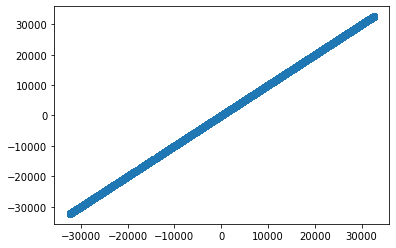

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.scatter(transformed[:,:], transformed[:,:]);

In [84]:
pca.components_

array([[ 1.00000000e+00, -1.89125474e-07, -1.28707173e-07, ...,
        -1.18657047e-07, -1.22762178e-07, -1.96753388e-07],
       [-2.60022865e-06, -5.00097029e-02, -5.16187198e-02, ...,
        -6.83421762e-02, -6.93218240e-02, -4.96090780e-02],
       [-4.61978616e-07,  2.69986437e-02, -1.59768231e-02, ...,
        -3.00094472e-03, -2.36584448e-03, -3.01634707e-02],
       ...,
       [ 5.81553252e-10, -1.27273272e-03,  5.86921732e-04, ...,
         1.69867458e-02,  9.21565903e-03, -2.10880454e-04],
       [ 7.68312925e-10,  2.08903044e-03,  1.35999784e-03, ...,
         3.97708906e-04, -4.77805416e-03, -1.21441234e-04],
       [ 8.82617509e-11, -8.56375932e-04,  7.40508279e-05, ...,
         9.77705977e-04,  8.41811267e-04, -1.98675325e-04]])

In [85]:
pca.mean_

array([ 3.23594639e+04, -2.19390323e+00, -2.20285444e+00, -2.20739055e+00,
       -2.19403967e+00, -2.16149652e+00, -2.04511030e+00, -2.20243310e+00,
       -2.20320729e+00, -2.10780814e+00, -2.19315472e+00, -2.16594426e+00,
       -2.20890938e+00, -2.17278567e+00, -2.13686324e+00, -2.20944271e+00,
       -2.09522064e+00, -2.18425210e+00, -2.20044495e+00, -2.20656411e+00,
       -2.18896778e+00, -2.19841555e+00, -2.20102207e+00, -2.20922440e+00,
       -2.20123478e+00, -2.20609691e+00, -2.20266965e+00, -2.18856293e+00,
       -2.20569935e+00, -2.10881912e+00, -2.19517399e+00, -2.20879503e+00,
       -2.20173641e+00, -2.20609590e+00, -2.18727318e+00, -2.18838508e+00,
       -2.20462459e+00, -1.88301728e+00, -2.19845866e+00, -2.20622696e+00,
       -2.20565041e+00, -2.18143644e+00, -2.20414484e+00, -2.05377586e+00,
       -2.19334803e+00, -2.19257986e+00, -2.20595635e+00, -2.19624834e+00,
       -2.20230957e+00, -2.00939652e+00, -2.19851929e+00, -2.20054663e+00,
       -2.20618021e+00, -

In [86]:
pca.explained_variance_ratio_

array([9.99999998e-01, 7.70901454e-10, 1.82531767e-10, 7.76356657e-11,
       4.20201370e-11, 3.91452308e-11, 3.57054904e-11, 2.83733585e-11,
       2.55560533e-11, 2.40473496e-11, 2.08441794e-11, 1.94904944e-11,
       1.87736830e-11, 1.74864276e-11, 1.60725905e-11, 1.56856976e-11,
       1.31763939e-11, 1.29819941e-11, 1.23575585e-11, 1.13403196e-11,
       1.05276834e-11, 1.00113769e-11, 1.00028780e-11, 9.02840896e-12,
       8.64289286e-12, 8.47927201e-12, 8.37864231e-12, 7.42728742e-12,
       7.16782634e-12, 7.09126675e-12, 6.89534241e-12, 6.63109844e-12,
       6.17163037e-12, 5.98804993e-12, 5.83886811e-12, 5.38233848e-12,
       5.36086331e-12, 5.13204151e-12, 5.01446665e-12, 4.66566155e-12,
       4.50314821e-12, 4.35547519e-12, 4.21828665e-12, 4.05664807e-12,
       3.83577601e-12, 3.73087743e-12, 3.61340134e-12, 3.57361011e-12,
       3.44379682e-12, 3.36604934e-12, 3.22820762e-12, 3.15424269e-12,
       3.07337709e-12, 2.99077543e-12, 2.94077352e-12, 2.83734427e-12,
      

In [87]:
np.cumsum(pca.explained_variance_ratio_)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### EDA

Visualizing and understanding the data.

In [ ]:
#1 indicates True and 0 indicates False

Text(0, 0.5, 'Frequency')

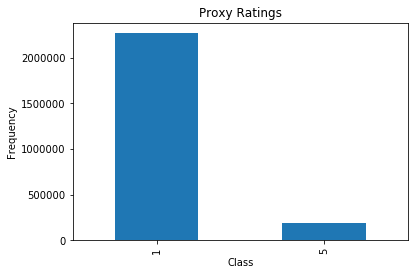

In [295]:
count_classes = pd.value_counts(df['rating'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Proxy Ratings")
plt.xlabel("Class")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

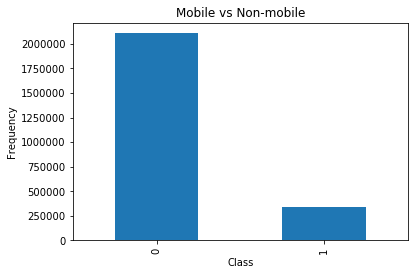

In [290]:
count_classes = pd.value_counts(df['is_mobile'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Mobile vs Non-mobile")
plt.xlabel("Class")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

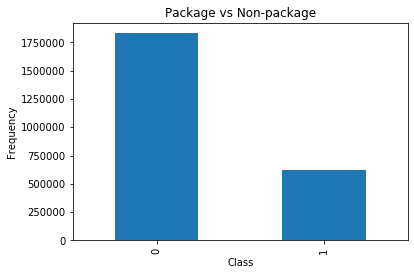

In [294]:
count_classes = pd.value_counts(df['is_package'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Package vs Non-package")
plt.xlabel("Class")
plt.ylabel("Frequency")

Text(0.5, 1, 'Correlation between fearures')

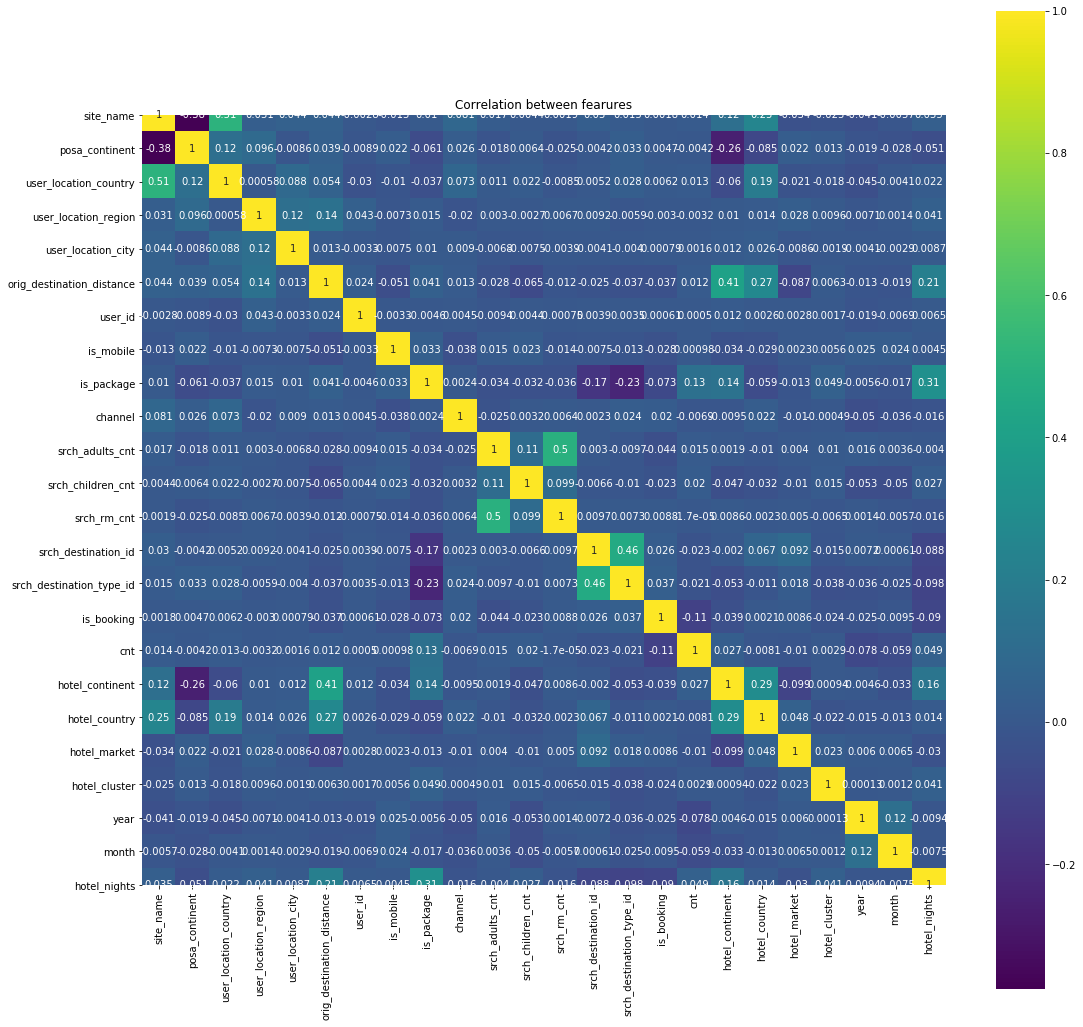

In [124]:
#Plot a correlation matrix using a heatmap to explore the correlation between features.
correlation = df.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')
plt.title('Correlation between fearures')

In [ ]:
#Not much correlation between features

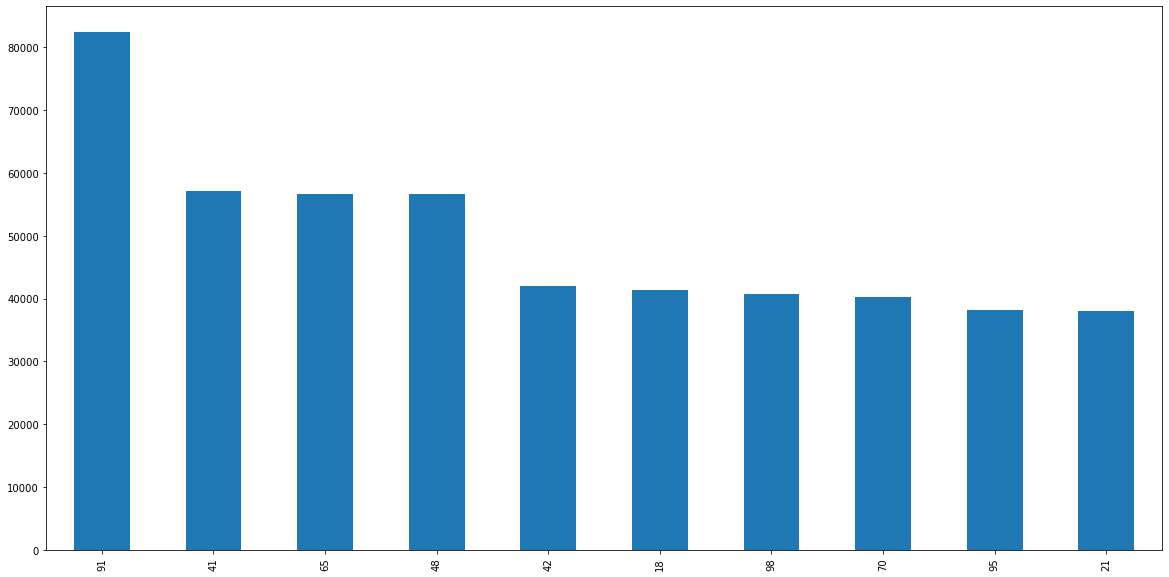

In [125]:
#The most popular hotel type is hotel cluster 91 which is marginally greater than the other clusters.
hotel_clusters = df[['hotel_cluster']].stack().value_counts()
hotel_clusters = hotel_clusters[:10]

hotel_clusters.plot(kind="bar", figsize=(20,10));

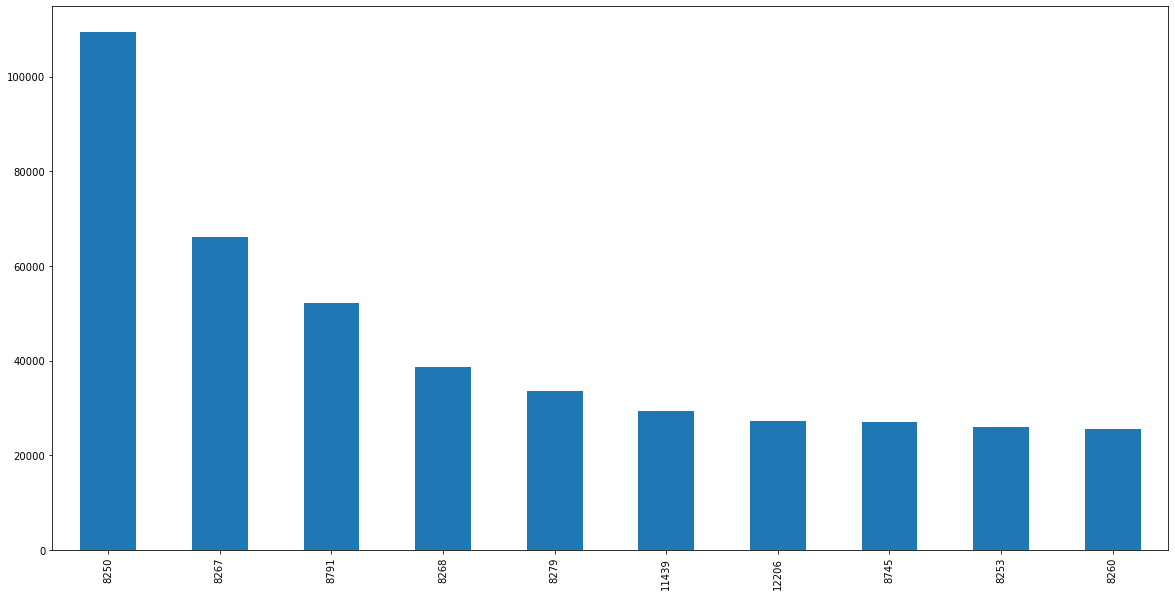

In [126]:
#Most searches are performed in id 8250.
srch_destination_ids = df[['srch_destination_id']].stack().value_counts()
srch_destination_ids = srch_destination_ids[:10]

srch_destination_ids.plot(kind="bar", figsize=(20,10));

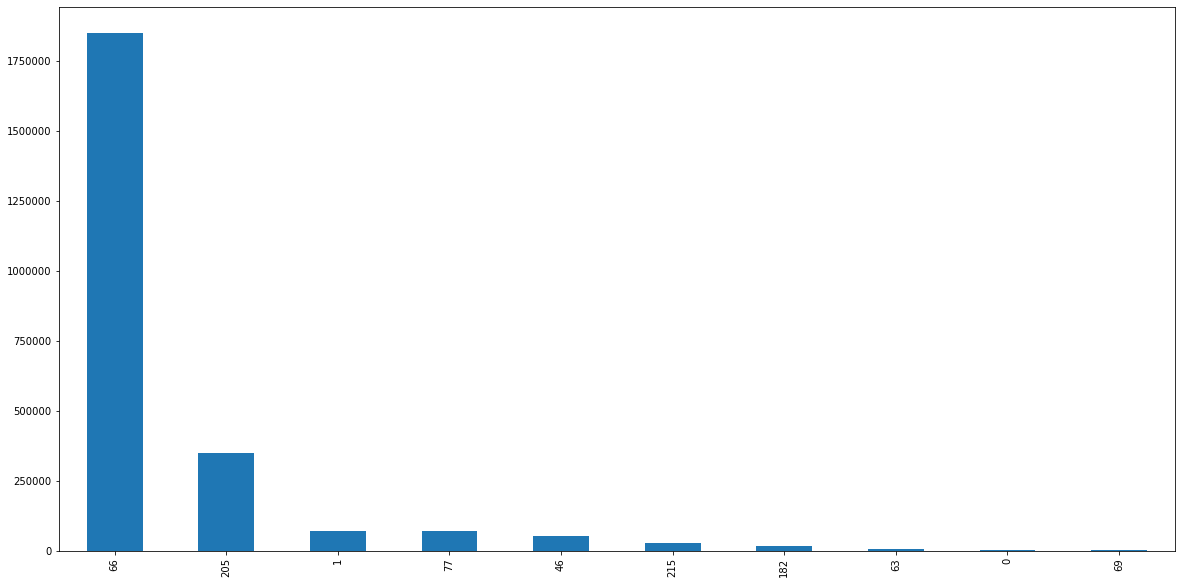

In [153]:
#We can observe that most users looking for hotels to stay at are from country 66.
user_location_country = df[['user_location_country']].stack().value_counts()
user_location_country = user_location_country[:10]

user_location_country.plot(kind="bar", figsize=(20,10));

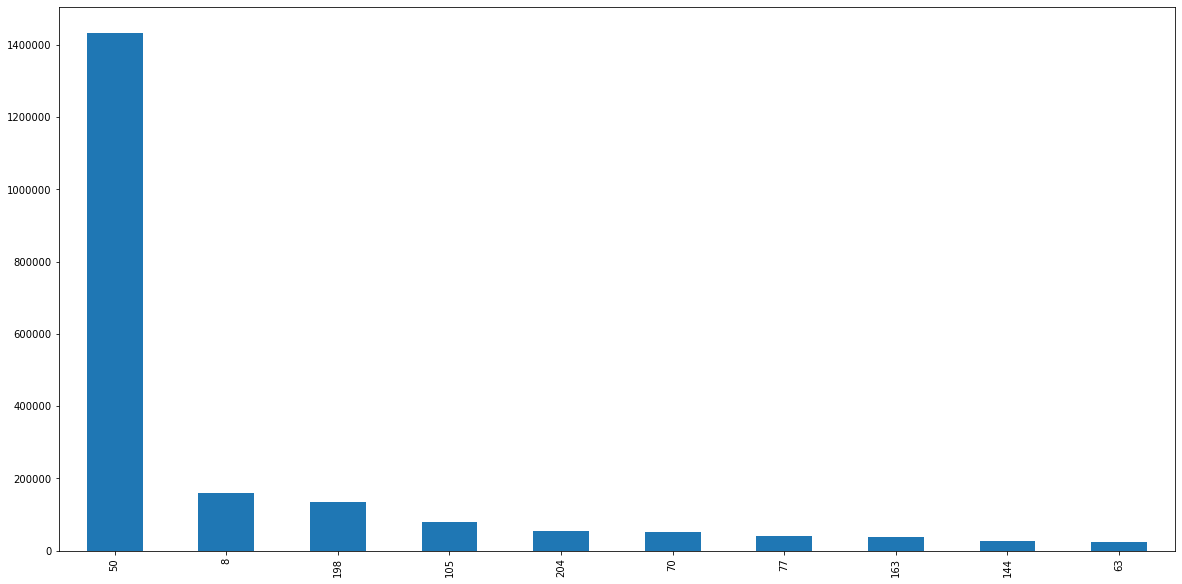

In [154]:
#We can see that a majority of people are looking at hotels in country 50.
hotel_country = df[['hotel_country']].stack().value_counts()
hotel_country = hotel_country[:10]

hotel_country.plot(kind="bar", figsize=(20,10));

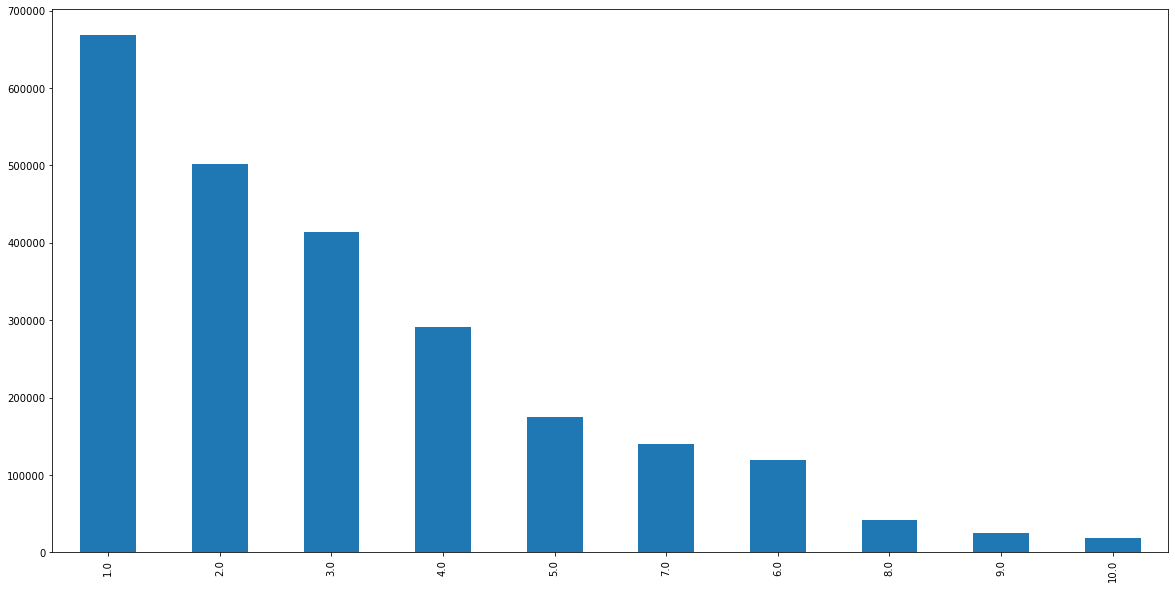

In [260]:
#The most popular hotel type is hotel cluster 91 which is marginally greater than the other clusters.
hotel_nights = df[['hotel_nights']].stack().value_counts()
hotel_nights = hotel_nights[:10]

hotel_nights.plot(kind="bar", figsize=(20,10));

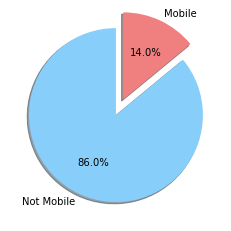

In [149]:
labels = 'Not Mobile', 'Mobile'
colors = ['lightskyblue', 'lightcoral'] 
explode = (0, 0.2)    

is_mobile = df[['is_mobile']].stack().value_counts()
plt.pie(is_mobile, explode=explode,labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90);

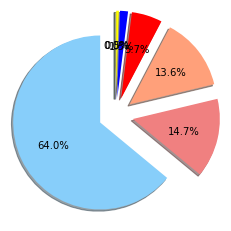

In [150]:
colors = ['lightskyblue', 'lightcoral', 'lightsalmon','red', 'blue', 'yellow'] 
explode = (0.2 , 0.2, 0.2, 0.2, 0.2, 0.2, 0.2)    

hotel_continent = df[['hotel_continent']].stack().value_counts()
plt.pie(hotel_continent, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90);

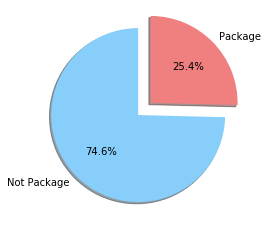

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

labels = 'Not Package', 'Package'
colors = ['lightskyblue', 'lightcoral'] 
explode = (0, 0.2)    

is_mobile = df[['is_package']].stack().value_counts()
plt.pie(is_mobile, explode=explode,labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90);

In [156]:
byHotelUserCountryBooking = byhotel_country = df.groupby(['user_location_country','hotel_country','is_booking'])
byHotelUserCountryBooking['is_booking'].agg([len]).sort_values(by='len', ascending=False).head(50)

len
user_location_country hotel_country is_booking         
66                    50            0           1123888
205                   50            0            134297
66                    8             0            128616
                      50            1            108865
205                   198           0             81321
66                    105           0             40197
                      198           0             37102
                      163           0             32350
                      204           0             30207
                      70            0             28162
                      77            0             18941
                      51            0             16884
                      47            0             15453
205                   8             0             14753
1                     105           0             14268
77                    63            0             13674
                      50            0             13599
46                    50            0             11502
205                   105           0             11423
66                    106           0             11332
                      182           0             11086
205                   198           1             10667
215                   50            0             10244
66                    144           0              9945
205                   50            1              9821
66                    128           0              9644
                      146           0              8727
205                   204           0              8324
66                    99            0              7987
1                     50            0              7967
205                   70            0              7920
215                   8             0              7897
1                     77            0              7519
46                    144           0              7284
182                   50            0              7193
66                    208           0              6982
                      96            0              6375
                      22            0              5878
                      68            0              5865
                      82            0              5679
205                   77            0              5664
66                    31            0              5282
77                    5             0              5265
66                    171           0              5230
1                     204           0              5196
66                    48            0              5089
                      63            0              4895
                      32            0              4629
                      8             1              4584
                      104           0              4558

In [296]:
df.head(2)

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,hotel_nights,rating
0,2,3,66,348,48862,2234.2641,12,0,1,9,2,0,1,8250,1,3,2,50,628,1,2014,8,4.0,1
1,2,3,66,348,48862,2234.2641,12,0,1,9,2,0,1,8250,1,1,2,50,628,1,2014,8,4.0,5


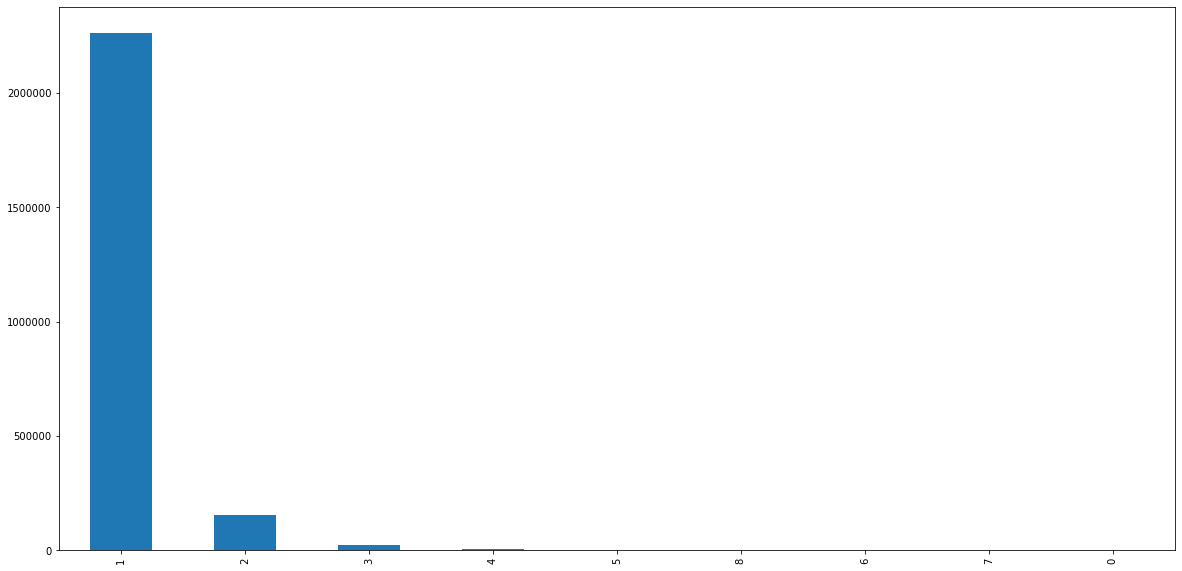

In [299]:
#Seeing the typical amount of rooms entered in a search query
room_s = df[['srch_rm_cnt']].stack().value_counts()
room_s = room_s[:10]

room_s.plot(kind="bar", figsize=(20,10));

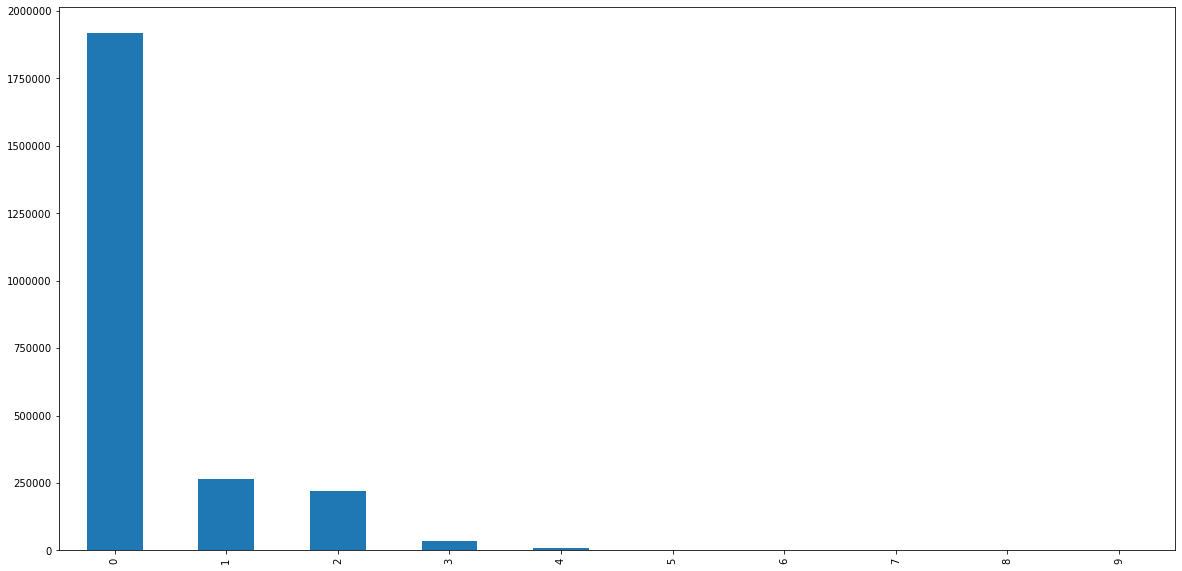

In [298]:
#Seeing the typical amount of children entered in a search query
child_s = df[['srch_children_cnt']].stack().value_counts()
child_s = child_s[:10]

child_s.plot(kind="bar", figsize=(20,10));

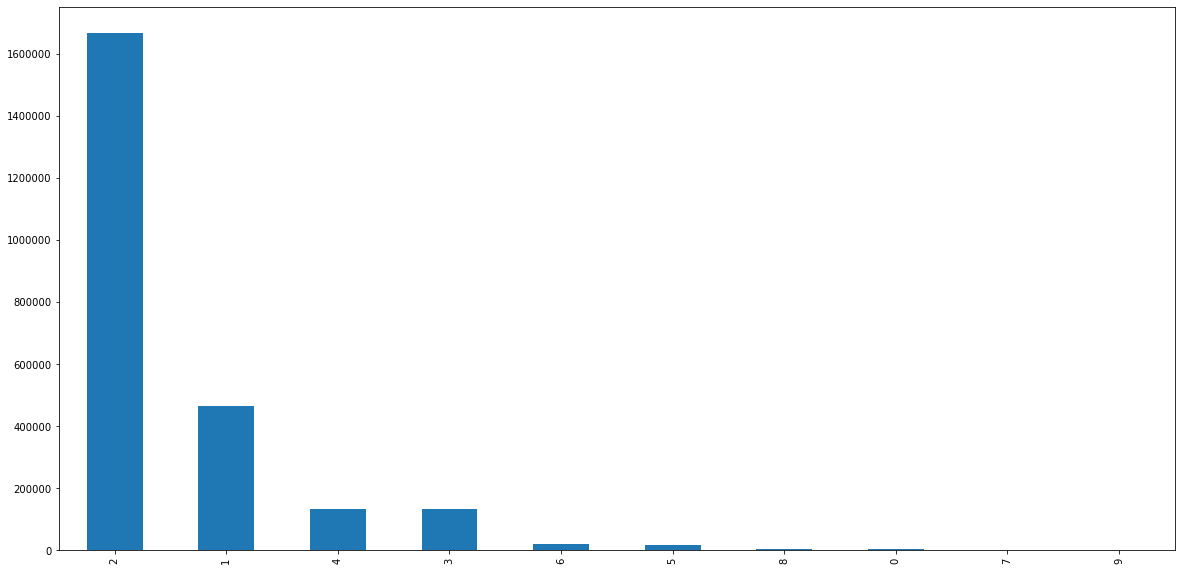

In [297]:
#Seeing the typical amount of adults entered in a search query
adult_s = df[['srch_adults_cnt']].stack().value_counts()
adult_s = adult_s[:10]

adult_s.plot(kind="bar", figsize=(20,10));

### Clustering and Preparation

Preparing data to feed into clustering algorithm to group users into 1000 clusters.
This makes matrix factorization possible within the algorithm rather than computing to 1 million users. 

In [25]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

In [ ]:
#HAC over KMeans because it considers individual relationships when each point is a cluster as opposed to random
#predefined number of clusters(KMeans)

#Look at dedogram to determine optimal number of clusters

In [34]:
df.head(2)

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,hotel_nights,rating
0,2,3,66,348,48862,2234.2641,12,0,1,9,2,0,1,8250,1,3,2,50,628,1,2014,8,4.0,1
1,2,3,66,348,48862,2234.2641,12,0,1,9,2,0,1,8250,1,1,2,50,628,1,2014,8,4.0,5


In [26]:
user = pd.DataFrame()

In [27]:
user['user_location_country'] = df['user_location_country']
user['user_location_region'] = df['user_location_region']
user['user_location_city'] = df['user_location_city']
user['user_id'] = df['user_id']
user['hotel_cluster'] = df['hotel_cluster']
user['rating'] = df['rating']
user['is_mobile'] = df['is_mobile']

In [28]:
user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2451439 entries, 0 to 4114152
Data columns (total 7 columns):
user_location_country    int64
user_location_region     int64
user_location_city       int64
user_id                  int64
hotel_cluster            int64
rating                   int64
is_mobile                int64
dtypes: int64(7)
memory usage: 149.6 MB


In [28]:
user['user_id'].nunique()

98940

In [29]:
table = pd.pivot_table(user, values='rating', index='user_id', columns=['hotel_cluster'], \
                       aggfunc=np.mean, fill_value=0)
table

hotel_cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,2.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,1.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198707,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.444444,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.0,0.0,1.0,1.0,1.0,0.0,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1198716,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1198719,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,

Preparing a dataframe to feed into LightFM dataset object format and modeling purposes.

Review this step after the clustering below. 

In [238]:
#Creating a new table to have item features for each user_id, will be explained later.
#Using median because mean doesn't represent when a user looks at hotels from different places. Instead median()
#captures preference and has better accuracy than if using mean()
table2 = df.groupby(['user_id']).max()
table2

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,hotel_nights,rating
user_id,,,,,,,,,,,,,,,,,,,,,,,
4,2,3,66,258,45545,1321.0614,0,0,9,6,2,1,11624,6,1,2,50,1343,73,2014,12,4.0,1
12,2,3,66,348,48862,2234.2641,0,1,9,2,0,1,8250,1,3,2,50,628,1,2014,8,4.0,5
15,2,3,66,174,44951,7146.5761,1,1,9,2,0,1,43446,4,3,4,171,664,91,2014,12,4.0,5
20,2,3,66,142,17440,3371.9237,0,1,1,2,0,1,8230,1,1,2,50,690,91,2014,10,4.0,5
22,2,3,66,442,37449,590.7978,1,0,9,2,0,1,44976,1,1,2,50,1634,80,2014,10,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198707,2,3,66,459,54425,1761.3092,0,1,2,5,2,2,16864,6,6,4,163,1508,87,2014,4,5.0,5
1198716,2,3,66,220,47307,926.8060,1,0,9,4,0,1,44045,6,3,2,50,701,83,2014,12,3.0,5
1198719,2,3,66,337,1057,1528.4804,1,1,4,2,1,1,8791,1,2,4,8,110,66,2014,7,4.0,1


In [252]:
table3 = pd.DataFrame()

In [261]:
table3['user_location_country'] = table2['user_location_country']
table3['user_location_city'] = table2['user_location_city']
table3['user_location_region'] = table2['user_location_region']
table3['is_package'] = table2['is_package']
table3['is_mobile'] = table2['is_mobile']

In [262]:
table_f = table.merge(table3, on='user_id')
table_f.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,cluster,user_location_country,user_location_city,user_location_region,is_package,is_mobile
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,136,66,45545,258,0,0
12,0.0,2.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,472,66,48862,348,1,0


In [255]:
post_final = pd.DataFrame()

In [257]:
post_final['cluster'] = table_f['cluster']
post_final['user_country'] = table_f['user_location_country']
post_final['user_region'] = table_f['user_location_region']
post_final['user_city'] = table_f['user_location_city']
post_final['package'] = table_f['is_package']

In [258]:
#Median is perfect to get some representation of item features for a cluster of users. YES!
import scipy
post_final = post_final.groupby('cluster').agg(lambda x: scipy.stats.mode(x)[0])
post_final.head(2)

,user_country,user_region,user_city,package
cluster,,,,
0,66,442,36086,1
1,66,174,48862,1


In [259]:
#This is a item-feature matrix that will be used for modeling
post_final.to_csv('post_final')

In [272]:
#Creating a matrix to build user-profile for Decision Tree Classifier
decision_df = pd.DataFrame()
decision_df['cluster'] = table_f['cluster']
decision_df['user_country'] = table_f['user_location_country']
decision_df['user_region'] = table_f['user_location_region']
decision_df['user_city'] = table_f['user_location_city']
decision_df['package'] = table_f['is_package']
decision_df['mobile'] = table_f['is_mobile']

In [282]:
decision_df = decision_df.reset_index().drop(['user_id'], axis=1)

In [285]:
decision_df.drop(['index'], axis=1, inplace=True)

In [287]:
decision_df

,cluster,user_country,user_region,user_city,package,mobile
0,136,66,258,45545,0,0
1,472,66,348,48862,1,0
2,782,66,174,44951,1,1
3,821,66,142,17440,1,0
4,515,66,442,37449,0,1
...,...,...,...,...,...,...
98935,748,66,459,54425,1,0
98936,885,66,220,47307,0,1
98937,244,66,337,1057,1,1
98938,601,66,322,54285,1,1


In [288]:
decision_df.to_csv('decision_df')

In [30]:
#Save as csv so I don't have to go through cleaning steps when restarting kernel for algos.
table.to_csv('utility')

In [31]:
table[3].unique()

array([0.        , 1.        , 2.        , 2.33333333, 1.66666667,
       1.5       , 2.14285714, 3.        , 1.8       , 5.        ,
       1.57142857, 1.25      , 1.33333333, 1.44444444, 1.4       ,
       2.5       , 1.88888889, 1.61538462, 2.6       , 1.94117647,
       1.21052632, 1.36363636, 1.92307692, 1.22222222, 2.77777778])

In [118]:
for name, subset in user.groupby('user_id'):
    if len(subset['user_location_country'].unique()) != 1:
        print("error")
    if len(subset['user_location_region'].unique()) != 1:
        print("error")
    if len(subset['user_location_city'].unique()) != 1:
        print("error")

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

## Cluster Modeling 

1,000 users to help capture unique groups of users to make recommendations for.

In [32]:
clust = KMeans(n_clusters=1000)
km_model = clust.fit_predict(table)

In [33]:
unique, counts = np.unique(km_model, return_counts=True)

dict(zip(unique, counts))

{0: 27,
 1: 146,
 2: 295,
 3: 110,
 4: 30,
 5: 104,
 6: 40,
 7: 64,
 8: 30,
 9: 25,
 10: 62,
 11: 1446,
 12: 182,
 13: 86,
 14: 3,
 15: 37,
 16: 20,
 17: 50,
 18: 309,
 19: 130,
 20: 99,
 21: 6,
 22: 49,
 23: 63,
 24: 52,
 25: 30,
 26: 235,
 27: 105,
 28: 279,
 29: 76,
 30: 72,
 31: 187,
 32: 72,
 33: 64,
 34: 95,
 35: 312,
 36: 724,
 37: 146,
 38: 145,
 39: 71,
 40: 230,
 41: 354,
 42: 218,
 43: 61,
 44: 288,
 45: 67,
 46: 183,
 47: 82,
 48: 161,
 49: 61,
 50: 108,
 51: 198,
 52: 275,
 53: 79,
 54: 150,
 55: 38,
 56: 67,
 57: 94,
 58: 53,
 59: 50,
 60: 53,
 61: 71,
 62: 75,
 63: 445,
 64: 82,
 65: 62,
 66: 43,
 67: 56,
 68: 22,
 69: 247,
 70: 33,
 71: 349,
 72: 274,
 73: 39,
 74: 53,
 75: 284,
 76: 429,
 77: 22,
 78: 50,
 79: 84,
 80: 215,
 81: 54,
 82: 54,
 83: 26,
 84: 31,
 85: 24,
 86: 47,
 87: 106,
 88: 318,
 89: 282,
 90: 64,
 91: 25,
 92: 75,
 93: 31,
 94: 55,
 95: 69,
 96: 199,
 97: 36,
 98: 144,
 99: 12,
 100: 52,
 101: 233,
 102: 96,
 103: 128,
 104: 24,
 105: 37,
 106: 100,


In [34]:
pd.Series(clust.predict(table)).value_counts()

11     1446
36      724
144     639
434     594
468     557
       ... 
934       1
897       1
617       1
682       1
930       1
Length: 1000, dtype: int64

In [43]:
km_model

array([136, 472, 782, ..., 244, 601, 108], dtype=int32)

In [36]:
#Add each respective cluster to the dataframe.
table['cluster'] = km_model

In [47]:
table.head(2)

hotel_cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,cluster
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,136
12,0.0,2.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,472


In [61]:
final_df = table.groupby(['cluster']).mean()
final_df

hotel_cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.074074,0.133333,0.037037,0.111111,0.333333,0.074074,0.333333,0.234568,0.111111,0.037037,0.259259,0.037037,0.000000,0.259259,0.074074,0.148148,0.111111,0.259259,0.355556,0.382716,0.074074,0.148148,0.000000,0.259259,0.000000,0.111111,0.000000,0.000000,2.649383,0.037037,0.000000,0.000000,0.358025,0.296296,0.037037,0.037037,0.000000,0.037037,0.000000,0.264198,2.908832,0.370370,0.604938,0.123457,0.000000,0.148148,0.111111,0.370370,0.580247,0.234568,0.345679,0.222222,0.037037,0.037037,0.074074,0.209877,0.000000,0.000000,0.037037,0.271605,0.074074,0.000000,0.000000,0.037037,0.037037,0.074074,0.000000,0.037037,0.148148,0.074074,0.148148,0.037037,0.111111,0.037037,0.000000,0.000000,0.604938,0.296296,0.000000,0.074074,0.111111,0.000000,0.074074,0.543210,0.037037,0.000000,0.037037,0.074074,0.037037,0.074074,0.111111,0.488889,0.000000,0.037037,0.234568,0.000000,0.074074,0.037037,0.074074,0.000000
1,1.149392,0.045010,0.047945,0.054795,0.184682,0.232877,0.054795,0.047945,0.082192,0.375342,0.041096,0.041096,0.006849,0.041096,0.013699,0.041096,0.020548,0.300000,0.130137,0.386106,0.068493,0.864831,0.041096,0.075342,0.047945,0.149315,0.397717,0.006849,0.082192,0.020548,0.075342,0.075342,0.054795,0.662020,0.236301,0.006849,0.039726,0.308219,0.027397,0.034247,0.143836,0.805936,0.061644,0.020548,0.034247,0.075342,0.020548,0.041096,0.239726,0.089041,0.109589,0.150685,0.020548,0.027397,0.061644,0.281996,0.248858,0.006849,0.013699,0.075342,0.013699,0.013699,0.034247,0.034247,0.047945,0.116438,0.034247,0.013699,0.102740,0.089041,0.150685,0.082192,0.143836,0.273973,0.013699,0.068493,0.041096,0.123288,0.027397,0.058708,0.054795,0.013699,0.020548,0.431507,0.414873,0.034247,0.075342,0.082192,0.054795,0.104371,0.134051,0.205479,0.130137,0.061644,0.123288,0.171233,0.751402,0.102740,0.226027,0.095890
2,0.033898,0.003390,0.010169,0.023729,0.000000,1.058208,0.044068,0.020339,0.047458,0.040678,0.013559,0.006780,0.013559,0.003390,0.016949,0.020339,0.037288,0.010169,0.003390,0.006780,0.054237,0.040678,0.023729,0.016949,0.000000,0.033898,0.013559,0.013559,0.013559,0.000000,0.013559,0.010169,0.006780,0.013559,0.016949,0.020339,0.040678,0.050847,0.016949,0.006780,0.047458,0.030508,0.020339,0.003390,0.013559,0.007748,0.037288,0.010169,0.071186,0.030508,0.030508,0.033898,0.003390,0.027119,0.013559,0.027119,0.023729,0.013559,0.000000,0.057627,0.016949,0.044068,0.050847,0.023729,0.044068,0.027119,0.006780,0.006780,0.050847,0.010169,0.030508,0.023729,0.027119,0.006780,0.006780,0.033898,0.037288,0.006780,0.054237,0.010169,0.013559,0.010169,0.033898,0.054237,0.023729,0.016949,0.003390,0.013559,0.006780,0.003390,0.176271,0.006780,0.003390,0.010169,0.030508,0.016949,0.006780,0.027119,0.003390,0.013559
3,0.127273,0.072727,0.000000,0.027273,0.036364,0.090909,0.200000,0.018182,0.072727,0.045455,0.100000,0.018182,0.045455,0.018182,0.009091,0.045455,0.063636,0.228139,0.090909,0.045455,0.109091,0.054545,0.041558,0.045455,0.036364,0.054545,0.163636,0.018182,0.090909,0.027273,0.209091,0.396970,0.018182,0.063636,0.154545,0.009091,0.018182,0.054545,0.009091,0.018182,0.109091,0.081818,0.036364,0.027273,0.081818,0.009091,0.009091,0.100000,0.081818,0.009091,0.072727,0.118182,0.072727,0.009091,0.174215,0.009091,0.036364,0.036364,0.054545,0.072727,0.027273,0.172727,0.100000,0.100000,0.045455,0.846535,0.227273,0.000000,0.018182,0.018182,0.009091,0.127273,0.018182,0.054545,0.009091,0.118182,0.063636,0.109091,0.054545,0.045455,0.100000,0.036364,0.018182,0.141212,0.072727,0.129187,0.018182,0.932727,0.000000,0.109091,0.036364,0.045455,0.109091,0.054545,0.009091,0.036364,1.067965,0.00909

In [64]:
final_df[930:931]

hotel_cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
930,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,3.0,2.333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,2.142857,3.0,0.0,0.0,0.0,2.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In theory, this clustering of users helps with the original sparse utility matrix because the matrix is now
compressing users into clusters and averaging the rating for each hotel cluster by unique users.

In [66]:
final_df.to_csv('clustered_utility')

In [67]:
final_df.head()

hotel_cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.074074,0.133333,0.037037,0.111111,0.333333,0.074074,0.333333,0.234568,0.111111,0.037037,0.259259,0.037037,0.000000,0.259259,0.074074,0.148148,0.111111,0.259259,0.355556,0.382716,0.074074,0.148148,0.000000,0.259259,0.000000,0.111111,0.000000,0.000000,2.649383,0.037037,0.000000,0.000000,0.358025,0.296296,0.037037,0.037037,0.000000,0.037037,0.000000,0.264198,2.908832,0.370370,0.604938,0.123457,0.000000,0.148148,0.111111,0.370370,0.580247,0.234568,0.345679,0.222222,0.037037,0.037037,0.074074,0.209877,0.000000,0.000000,0.037037,0.271605,0.074074,0.000000,0.000000,0.037037,0.037037,0.074074,0.000000,0.037037,0.148148,0.074074,0.148148,0.037037,0.111111,0.037037,0.000000,0.000000,0.604938,0.296296,0.000000,0.074074,0.111111,0.000000,0.074074,0.543210,0.037037,0.000000,0.037037,0.074074,0.037037,0.074074,0.111111,0.488889,0.000000,0.037037,0.234568,0.000000,0.074074,0.037037,0.074074,0.000000
1,1.149392,0.045010,0.047945,0.054795,0.184682,0.232877,0.054795,0.047945,0.082192,0.375342,0.041096,0.041096,0.006849,0.041096,0.013699,0.041096,0.020548,0.300000,0.130137,0.386106,0.068493,0.864831,0.041096,0.075342,0.047945,0.149315,0.397717,0.006849,0.082192,0.020548,0.075342,0.075342,0.054795,0.662020,0.236301,0.006849,0.039726,0.308219,0.027397,0.034247,0.143836,0.805936,0.061644,0.020548,0.034247,0.075342,0.020548,0.041096,0.239726,0.089041,0.109589,0.150685,0.020548,0.027397,0.061644,0.281996,0.248858,0.006849,0.013699,0.075342,0.013699,0.013699,0.034247,0.034247,0.047945,0.116438,0.034247,0.013699,0.102740,0.089041,0.150685,0.082192,0.143836,0.273973,0.013699,0.068493,0.041096,0.123288,0.027397,0.058708,0.054795,0.013699,0.020548,0.431507,0.414873,0.034247,0.075342,0.082192,0.054795,0.104371,0.134051,0.205479,0.130137,0.061644,0.123288,0.171233,0.751402,0.102740,0.226027,0.095890
2,0.033898,0.003390,0.010169,0.023729,0.000000,1.058208,0.044068,0.020339,0.047458,0.040678,0.013559,0.006780,0.013559,0.003390,0.016949,0.020339,0.037288,0.010169,0.003390,0.006780,0.054237,0.040678,0.023729,0.016949,0.000000,0.033898,0.013559,0.013559,0.013559,0.000000,0.013559,0.010169,0.006780,0.013559,0.016949,0.020339,0.040678,0.050847,0.016949,0.006780,0.047458,0.030508,0.020339,0.003390,0.013559,0.007748,0.037288,0.010169,0.071186,0.030508,0.030508,0.033898,0.003390,0.027119,0.013559,0.027119,0.023729,0.013559,0.000000,0.057627,0.016949,0.044068,0.050847,0.023729,0.044068,0.027119,0.006780,0.006780,0.050847,0.010169,0.030508,0.023729,0.027119,0.006780,0.006780,0.033898,0.037288,0.006780,0.054237,0.010169,0.013559,0.010169,0.033898,0.054237,0.023729,0.016949,0.003390,0.013559,0.006780,0.003390,0.176271,0.006780,0.003390,0.010169,0.030508,0.016949,0.006780,0.027119,0.003390,0.013559
3,0.127273,0.072727,0.000000,0.027273,0.036364,0.090909,0.200000,0.018182,0.072727,0.045455,0.100000,0.018182,0.045455,0.018182,0.009091,0.045455,0.063636,0.228139,0.090909,0.045455,0.109091,0.054545,0.041558,0.045455,0.036364,0.054545,0.163636,0.018182,0.090909,0.027273,0.209091,0.396970,0.018182,0.063636,0.154545,0.009091,0.018182,0.054545,0.009091,0.018182,0.109091,0.081818,0.036364,0.027273,0.081818,0.009091,0.009091,0.100000,0.081818,0.009091,0.072727,0.118182,0.072727,0.009091,0.174215,0.009091,0.036364,0.036364,0.054545,0.072727,0.027273,0.172727,0.100000,0.100000,0.045455,0.846535,0.227273,0.000000,0.018182,0.018182,0.009091,0.127273,0.018182,0.054545,0.009091,0.118182,0.063636,0.109091,0.054545,0.045455,0.100000,0.036364,0.018182,0.141212,0.072727,0.129187,0.018182,0.932727,0.000000,0.109091,0.036364,0.045455,0.109091,0.054545,0.009091,0.036364,1.067965,0.00909

In [83]:
for x in final_df:
    print(final_df[x].describe())

count    1000.000000
mean        0.218465
std         0.308591
min         0.000000
25%         0.049080
50%         0.110788
75%         0.240418
max         3.708642
Name: 0, dtype: float64
count    1000.000000
mean        0.193624
std         0.416574
min         0.000000
25%         0.034161
50%         0.081081
75%         0.170523
max         5.000000
Name: 1, dtype: float64
count    1000.000000
mean        0.266730
std         0.414635
min         0.000000
25%         0.044363
50%         0.116341
75%         0.301087
max         3.000000
Name: 2, dtype: float64
count    1000.000000
mean        0.151542
std         0.225418
min         0.000000
25%         0.032194
50%         0.080541
75%         0.180700
max         3.034063
Name: 3, dtype: float64
count    1000.000000
mean        0.333386
std         0.549790
min         0.000000
25%         0.073953
50%         0.170732
75%         0.352246
max         5.000000
Name: 4, dtype: float64
count    1000.000000
mean        0.37435

count    1000.000000
mean        0.126894
std         0.252492
min         0.000000
25%         0.023173
50%         0.056604
75%         0.131579
max         5.000000
Name: 71, dtype: float64
count    1000.000000
mean        0.374312
std         0.483887
min         0.000000
25%         0.088766
50%         0.202803
75%         0.463503
max         3.056190
Name: 72, dtype: float64
count    1000.000000
mean        0.231547
std         0.303779
min         0.000000
25%         0.056780
50%         0.131255
75%         0.281250
max         3.038448
Name: 73, dtype: float64
count    1000.000000
mean        0.016686
std         0.030250
min         0.000000
25%         0.000000
50%         0.000000
75%         0.021419
max         0.296296
Name: 74, dtype: float64
count    1000.000000
mean        0.125342
std         0.224732
min         0.000000
25%         0.023810
50%         0.057143
75%         0.146793
max         3.000000
Name: 75, dtype: float64
count    1000.000000
mean        0.

It is there case where for each hotel cluster, there are max ratings of 5 and minimum ratings of 0.

In [73]:
final_df[0].isna().sum()

0

In [95]:
final_df[0].value_counts()

0.000000    62
0.166667     8
0.200000     8
1.000000     8
0.045455     7
            ..
0.033333     1
0.091837     1
0.603903     1
0.251462     1
0.015625     1
Name: 0, Length: 724, dtype: int64

In [96]:
#Looking at Sparse objects for memory efficiency. Sparse data structures within Python where 0s not stored.
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pylab as plt
import scipy.sparse as sparse

In [102]:
sdf = final_df.astype(pd.SparseDtype("float", 0))
sdf.dtypes

hotel_cluster
0     Sparse[float64, 0]
1     Sparse[float64, 0]
2     Sparse[float64, 0]
3     Sparse[float64, 0]
4     Sparse[float64, 0]
             ...        
95    Sparse[float64, 0]
96    Sparse[float64, 0]
97    Sparse[float64, 0]
98    Sparse[float64, 0]
99    Sparse[float64, 0]
Length: 100, dtype: object

In [103]:
#The % of values that are not compressed is relatively low. (The lower the density the more sparse)
sdf.sparse.density

0.90982

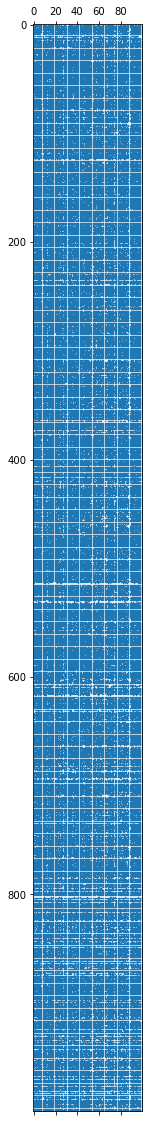

In [126]:
#Visualizing the Density matrix
plt.figure(figsize=(15, 20))
plt.spy(sdf, markersize=0.5)

In [146]:
sdf.head(2)

hotel_cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.074074,0.133333,0.037037,0.111111,0.333333,0.074074,0.333333,0.234568,0.111111,0.037037,0.259259,0.037037,0.000000,0.259259,0.074074,0.148148,0.111111,0.259259,0.355556,0.382716,0.074074,0.148148,0.000000,0.259259,0.000000,0.111111,0.000000,0.000000,2.649383,0.037037,0.000000,0.000000,0.358025,0.296296,0.037037,0.037037,0.000000,0.037037,0.000000,0.264198,2.908832,0.370370,0.604938,0.123457,0.000000,0.148148,0.111111,0.370370,0.580247,0.234568,0.345679,0.222222,0.037037,0.037037,0.074074,0.209877,0.000000,0.000000,0.037037,0.271605,0.074074,0.000000,0.000000,0.037037,0.037037,0.074074,0.000000,0.037037,0.148148,0.074074,0.148148,0.037037,0.111111,0.037037,0.000000,0.000000,0.604938,0.296296,0.000000,0.074074,0.111111,0.000000,0.074074,0.543210,0.037037,0.000000,0.037037,0.074074,0.037037,0.074074,0.111111,0.488889,0.000000,0.037037,0.234568,0.000000,0.074074,0.037037,0.074074,0.00000
1,1.149392,0.045010,0.047945,0.054795,0.184682,0.232877,0.054795,0.047945,0.082192,0.375342,0.041096,0.041096,0.006849,0.041096,0.013699,0.041096,0.020548,0.300000,0.130137,0.386106,0.068493,0.864831,0.041096,0.075342,0.047945,0.149315,0.397717,0.006849,0.082192,0.020548,0.075342,0.075342,0.054795,0.662020,0.236301,0.006849,0.039726,0.308219,0.027397,0.034247,0.143836,0.805936,0.061644,0.020548,0.034247,0.075342,0.020548,0.041096,0.239726,0.089041,0.109589,0.150685,0.020548,0.027397,0.061644,0.281996,0.248858,0.006849,0.013699,0.075342,0.013699,0.013699,0.034247,0.034247,0.047945,0.116438,0.034247,0.013699,0.102740,0.089041,0.150685,0.082192,0.143836,0.273973,0.013699,0.068493,0.041096,0.123288,0.027397,0.058708,0.054795,0.013699,0.020548,0.431507,0.414873,0.034247,0.075342,0.082192,0.054795,0.104371,0.134051,0.205479,0.130137,0.061644,0.123288,0.171233,0.751402,0.102740,0.226027,0.09589


In [136]:
#Convert to 3 column layout to feed into LightFM/SVD
sdf1 = sdf.sparse.to_coo()

In [186]:
sdf1

<1000x100 sparse matrix of type '<class 'numpy.float64'>'
	with 90982 stored elements in COOrdinate format>

In [184]:
#This makes it a series so from_spmatrix doesn't work. Has non null entries.
ss = pd.Series.sparse.from_coo(sdf1)

In [212]:
#Sparse Object
ss

0    0     0.074074
     1     0.133333
     2     0.037037
     3     0.111111
     4     0.333333
             ...   
999  95    0.271777
     96    0.209059
     97    0.634146
     98    0.658537
     99    0.390244
Length: 90982, dtype: Sparse[float64, nan]

In [188]:
svd_df = pd.DataFrame(ss)

In [192]:
svd_df.reset_index(inplace=True)  

In [193]:
svd_df.head(2)

,level_0,level_1,0
0,0,0,0.074074
1,0,1,0.133333


In [197]:
svd_df.rename(columns={'level_0':'user_clust', 'level_1':'hotel_clust', 0: 'rating'}, inplace=True)

In [206]:
#DataFrame format being fed into algorithms.
svd_df.head(2)

,user_clust,hotel_clust,rating
0,0,0,0.074074
1,0,1,0.133333


In [208]:
#Checking sparsity
numratings = len(svd_df['rating'])
numusers = len(svd_df['user_clust'].unique())
numhotels = len(svd_df['hotel_clust'].unique())
sparse = 1 - (numratings / (numusers*numhotels))
sparse

0.09018000000000004

In [210]:
svd_df.to_csv('s_df')

Testing HAC clustering as opposed to KMeans Clustering.

Initially preferred this clsutering algorithm because it initializes each data point in the subspace as a cluster so it theoretically captures more uniqueness/preferance in users when creating clusters as opposed to arbitrary initial points in KMeans.

However, because of the immensity of data, was unable to run this algorithm on the dataset. Would consider Google Collab in the future for potentially improved accuracy in user clusters. 

Here, could only run the algorithm on a small subset of the data after numerous attempts. 

In [85]:
table2 = table.iloc[:10000]

In [86]:
table2

hotel_cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
12,0.0,2.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
15,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,1.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
20,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
22,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127594,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.6,0.000000,1.0,0.0,1.0,1.0,0.0,1.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.285714,0.0,0.0,0.0,1.000000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0
127598,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,2.6,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.4,2.333333,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.0,0.0,1.0,0.0,0.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,1.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0

In [1]:
clust = AgglomerativeClustering()
user_clust = clust.fit_predict(table2)

NameError: name 'AgglomerativeClustering' is not defined

In [82]:
unique, counts = np.unique(user_clust, return_counts=True)

dict(zip(unique, counts))

{0: 516,
 1: 1266,
 2: 166,
 3: 190,
 4: 269,
 5: 147,
 6: 203,
 7: 1582,
 8: 519,
 9: 142}

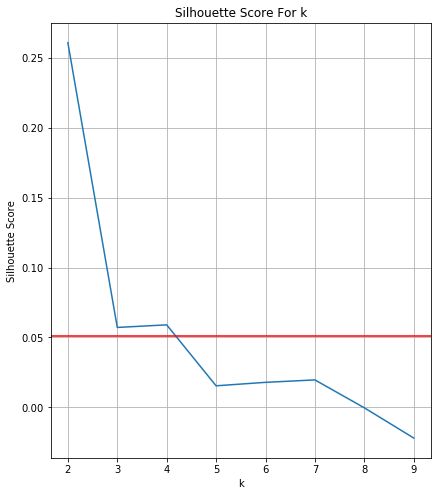

In [87]:
from sklearn import metrics

silhouette_plot = []
for k in range(2,10):
    clust = AgglomerativeClustering(n_clusters=k)
    user_clust = clust.fit_predict(table2)
    silhouette_avg = metrics.silhouette_score(table2, user_clust)
    silhouette_plot.append(silhouette_avg)

plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette Score For k')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.plot(range(2,10), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color='red', linestyle='-')
plt.grid(True)